# Homework Starter — Stage 08 EDA

Fill in the marked TODOs. This notebook generates synthetic data so you can focus on the EDA flow. Replace with your dataset when ready.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# === Synthetic data generator (adapt or replace with your own data) ===
n = 160
df = pd.DataFrame({
    'date': pd.date_range('2021-02-01', periods=n, freq='D'),
    'region': np.random.choice(['North','South','East','West'], size=n),
    'age': np.random.normal(40, 8, size=n).clip(22, 70).round(1),
    'income': np.random.lognormal(mean=10.6, sigma=0.3, size=n).round(2),
    'transactions': np.random.poisson(lam=3, size=n),
})
base = df['income'] * 0.0015 + df['transactions']*18 + np.random.normal(0, 40, size=n)
df['spend'] = np.maximum(0, base).round(2)

# inject a bit of missingness and outliers
df.loc[np.random.choice(df.index, 5, replace=False), 'income'] = np.nan
df.loc[np.random.choice(df.index, 3, replace=False), 'spend'] = np.nan
df.loc[np.random.choice(df.index, 2, replace=False), 'transactions'] = df['transactions'].max()+12
df.head()

,date,region,age,income,transactions,spend
0,2021-02-01,West,37.6,28086.81,4,73.35
1,2021-02-02,North,43.0,33034.75,1,52.37
2,2021-02-03,South,38.2,50045.39,2,131.85
3,2021-02-04,South,24.9,39467.28,4,147.58
4,2021-02-05,South,59.8,31201.65,1,86.76


## 1) First look

In [2]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          160 non-null    datetime64[ns]
 1   region        160 non-null    object        
 2   age           160 non-null    float64       
 3   income        155 non-null    float64       
 4   transactions  160 non-null    int32         
 5   spend         157 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 7.0+ KB


(None,
 date            0
 region          0
 age             0
 income          5
 transactions    0
 spend           3
 dtype: int64)

## 2) Numeric profile

In [3]:
desc = df[['age','income','transactions','spend']].describe().T
desc['skew'] = [skew(df[c].dropna()) for c in desc.index]
desc['kurtosis'] = [kurtosis(df[c].dropna()) for c in desc.index]
desc

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
age,160.0,40.018750,8.458676,22.00,34.70,40.15,44.925,61.10,0.069538,-0.080125
income,155.0,41983.866323,13262.457038,17928.80,32471.53,39332.52,49697.690,87052.40,0.993336,0.918722
transactions,160.0,3.237500,2.585610,0.00,2.00,3.00,4.000,20.00,3.466078,19.984802
spend,157.0,117.291592,51.768645,0.54,77.25,119.32,153.340,280.05,0.130860,-0.084917


## 3) Distributions

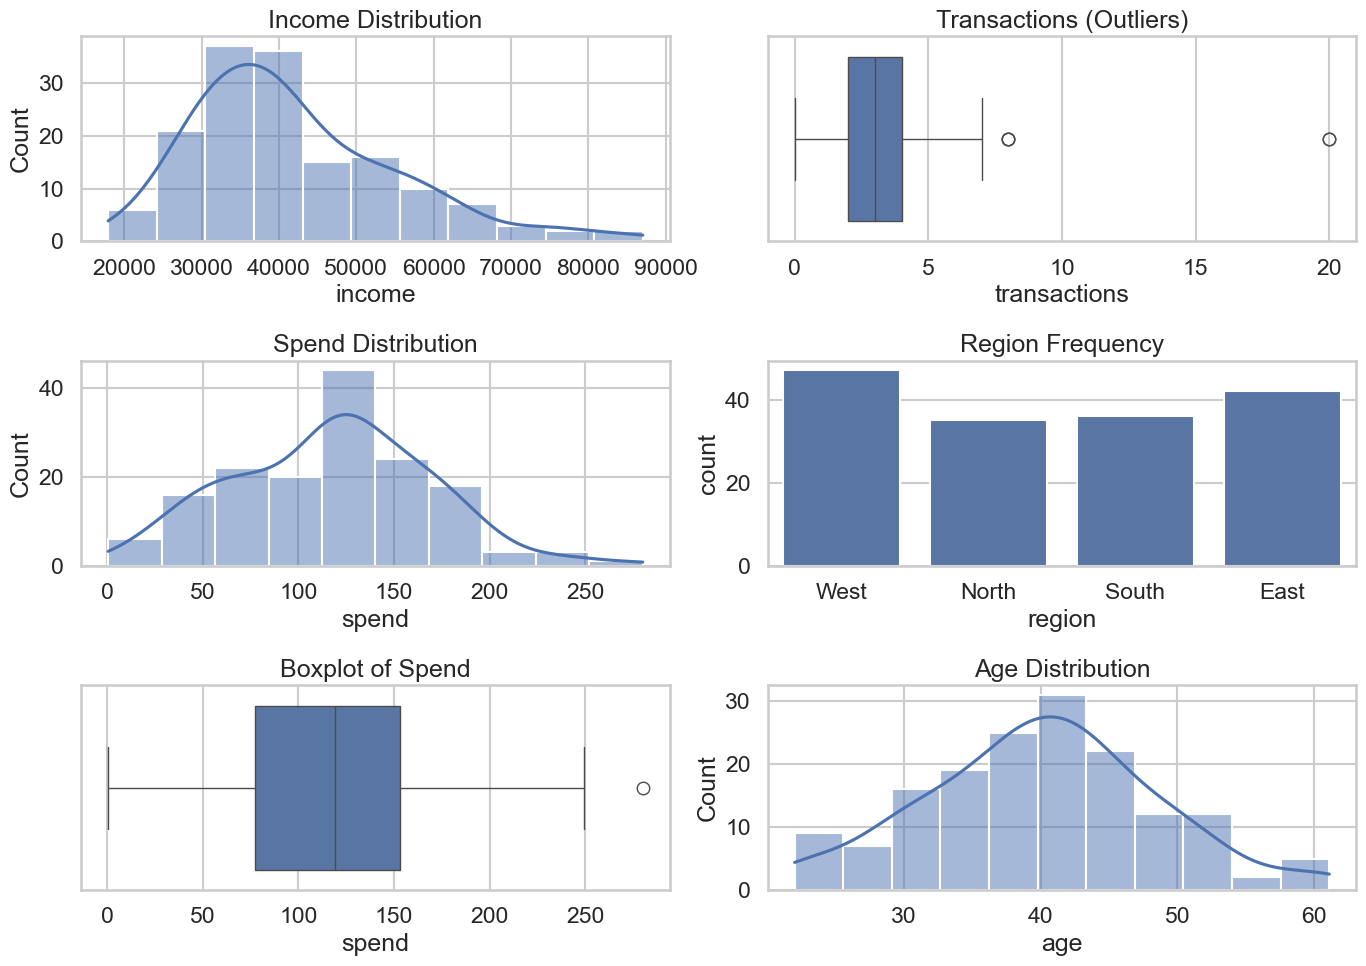

In [28]:
fig, axes = plt.subplots(3,2, figsize=(14,10))

sns.histplot(df['income'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Income Distribution')

sns.boxplot(x=df['transactions'], ax=axes[0,1])
axes[0,1].set_title('Transactions (Outliers)')

sns.histplot(df['spend'], kde=True, ax=axes[1,0])
axes[1,0].set_title('Spend Distribution')

sns.countplot(x=df['region'], ax=axes[1,1])
axes[1,1].set_title('Region Frequency')

sns.boxplot(x=df['spend'], ax=axes[2,0])
axes[2,0].set_title('Boxplot of Spend')

sns.histplot(df['age'], kde=True, ax=axes[2,1])
axes[2,1].set_title("Age Distribution")

plt.tight_layout()
plt.show()

## 4) Relationships

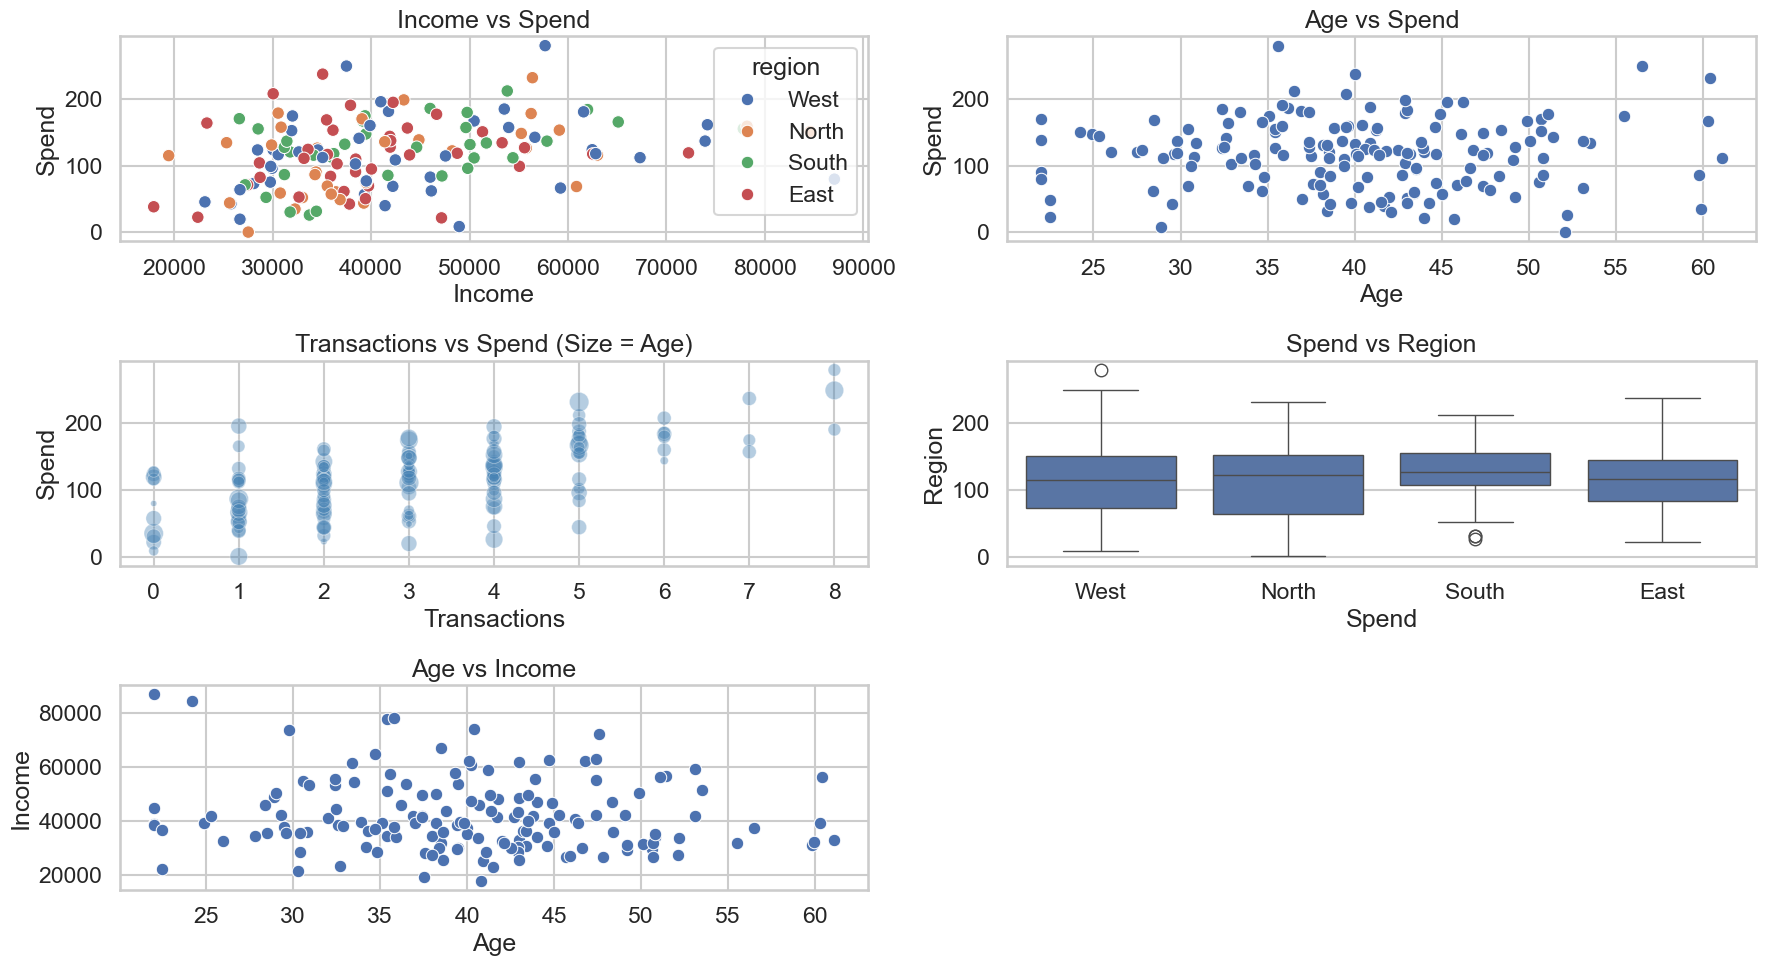

In [39]:
# Remove outliers in 'transactions'
df_filtered = df[df['transactions'] <= df['transactions'].quantile(0.99)]

fig, axes = plt.subplots(3, 2, figsize=(18, 10))

# Plot 1: Income vs Spend
sns.scatterplot(data=df, x='income', y='spend', hue='region', ax=axes[0,0])
axes[0,0].set_title('Income vs Spend')
axes[0,0].set_xlabel('Income')
axes[0,0].set_ylabel('Spend')

# Plot 2: Age vs Spend
sns.scatterplot(data=df, x='age', y='spend', ax=axes[0,1])
axes[0,1].set_title('Age vs Spend')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Spend')

# Plot 3: Spend vs Region
sns.boxplot(data=df, x='region', y='spend', ax=axes[1,1])
axes[1,1].set_title('Spend vs Region')
axes[1,1].set_xlabel('Spend')
axes[1,1].set_ylabel('Region')

# Plot 4: Transactions vs Spend — one color, transparency, size by age
sns.scatterplot(
    data=df_filtered,
    x='transactions', y='spend',
    size='age', sizes=(20, 200),  # scale bubble sizes
    color='steelblue', alpha=0.4, ax=axes[1,0], legend=False
)
axes[1,0].set_title('Transactions vs Spend (Size = Age)')
axes[1,0].set_xlabel('Transactions')
axes[1,0].set_ylabel('Spend')

# Plot 5: Age vs Income
sns.scatterplot(data=df, x='age', y='income', ax=axes[2,0])
axes[2,0].set_title('Age vs Income')
axes[2,0].set_xlabel('Age')
axes[2,0].set_ylabel('Income')

axes[2,1].axis("off")

plt.tight_layout()
plt.show()

## 5) Correlation matrix

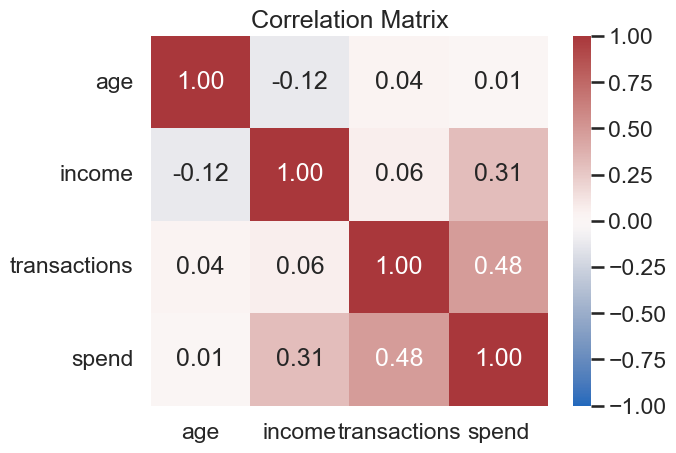

,age,income,transactions,spend
age,1.000000,-0.123160,0.037754,0.008174
income,-0.123160,1.000000,0.063573,0.307307
transactions,0.037754,0.063573,1.000000,0.480685
spend,0.008174,0.307307,0.480685,1.000000


In [41]:
corr = df[['age','income','transactions','spend']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
corr

In [42]:
def eda_summary(df: pd.DataFrame, numeric_cols=None):
    """Return a dict with quick profiling stats and basic missingness.
    numeric_cols: optional list to limit numeric profiling.
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = {}
    out['shape'] = df.shape
    out['dtypes'] = df.dtypes.to_dict()
    out['missing'] = df.isna().sum().to_dict()
    profile = df[numeric_cols].describe().T
    profile['skew'] = [skew(df[c].dropna()) for c in profile.index]
    profile['kurtosis'] = [kurtosis(df[c].dropna()) for c in profile.index]
    out['numeric_profile'] = profile
    return out

summary = eda_summary(df)
summary['shape'], list(summary['dtypes'].items())[:3]

((160, 6),
 [('date', dtype('<M8[ns]')),
  ('region', dtype('O')),
  ('age', dtype('float64'))])

## 6) Insights & Assumptions (write your commentary)
- Top 3 insights
1. Income distribution is right-skewed. The mean income is higher than the median, and the skewness is 0.99.
2. Transactions and spend are moderately correlated. Correlation coefficient between transactions and spend is 0.48, suggesting that more transactions generally lead to higher spending.
3. Age and spend are weakly correlated. Correlation coefficient between age and spend is 0.01, suggesting that age rarely influence spend.

- Assumptions & risks

1. Missing values
Some columns have missing entries (income: 5 missing, spend: 3 missing).
Assumption: missing values are either random (MCAR) or small enough in proportion that removing/filling them will not bias results.

2. Outliers
Extreme values in income and transactions exist.
Assumption: they represent true high-income or high-activity observations, not errors.
Risk: could skew scaling or regression results if not handled properly.

- Next steps before modeling (cleaning & features)
1. Handle Missing Values
Impute income and spend using median or model-based methods.

2. Treat Outliers
Cap or remove extreme transactions values to reduce skew impact.

3. Feature Engineering
Create derived features such as spend per transaction or income brackets.
Extract temporal features from date (day of week, month, week of year) to capture seasonality.

4. Categorical Processing
Encode region appropriately (one-hot or embedding) for modeling.

5. Scaling & Normalization
Standardize numeric columns (income, spend, transactions, age).